## 使用 TensorFlow 搭建神经网络预测泰坦尼克号乘客生存率

比赛地址：[Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic)

比赛内容：给定大量泰坦尼克号的乘客信息数据，要求预测乘客是否生存

比赛思路：典型的二分类问题，本文搭建多层感知机（MLP）解决

本文将从以下几方面介绍解决方案：
1. 添加库
2. 定义全局变量
3. 加载数据文件
4. **数据可视化**
5. **清洗数据**
6. **特征工程**
7. **搭建神经网络（前向传播）**
8. **训练（反向传播）**
9. **测试模型效果 && 生成提交结果**

## 1. 添加库

In [7]:
import tensorflow as tf
import model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. 定义全局变量

In [8]:
train_data_file = r'./data/train.csv'
test_data_file = r'./data/test.csv'
test_label_file = r'./data/gender_submission.csv'
model_save_path = r'./ckpt/model'
output_file = r'./result.csv'

learning_rate = 0.001
BATCH_SIZE = 20

input_size = 11
hidden_size = 20
output_size = 2

epoch = 2000
KEEP_PROB = 0.5

## 3. 加载数据文件

In [9]:
data = pd.read_csv(train_data_file, 
    sep=',', 
    dtype={
        'Name' : 'str',
        'Survived' : 'int64',
        'Pclass' : 'float32',   
        'Sex' : 'str',
        'Age' : 'float32',
        'SibSp' : 'float32',
        'Parch' : 'float32',
        'Fare' : 'float32',
        'Embarked' : 'str',
    }
)

In [10]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.250000,NaN,S
1,2,1,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.283302,C85,C
2,3,1,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.925000,NaN,S
3,4,1,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.099998,C123,S
4,5,0,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.050000,NaN,S
5,6,0,3.0,"Moran, Mr. James",male,NaN,0.0,0.0,330877,8.458300,NaN,Q
6,7,0,1.0,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,17463,51.862499,E46,S
7,8,0,3.0,"Palsson, Master. Gosta Leonard",male,2.0,3.0,1.0,349909,21.075001,NaN,S
8,9,1,3.0,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0.0,2.0,347742,11.133300,NaN,S
9,10,1,2.0,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1.0,0.0,237736,30.070801,NaN,C


乘客信息说明：
* PassengerId => 乘客ID
* Pclass => 客舱等级(1/2/3等舱位)
* Name => 乘客姓名
* Sex => 性别
* Age => 年龄
* SibSp => 兄弟姐妹数/配偶数
* Parch => 父母数/子女数
* Ticket => 船票编号
* Fare => 船票价格
* Cabin => 客舱号
* Embarked => 登船港口

In [11]:
# 生成简要的统计信息
# count  - 数量
# mean   - 均值
# std    - 标准差
# min    - 最小值
# 25%    - 下四分位
# 50%    - 中位数
# 75%    - 上四分位
# max    - 最大值
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102744,0.806057,49.693428
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329224


## 4. 数据可视化

In [12]:
# 性别与是否生存的关系 Sex
data.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

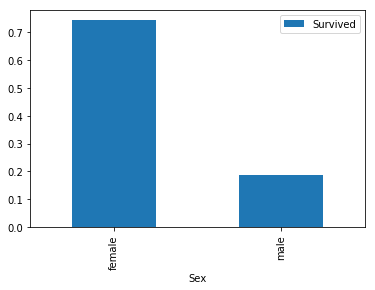

In [13]:
data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()

In [14]:
# 船舱等级和生存与否的关系 Pclass
data.groupby(['Pclass','Survived'])['Pclass'].count()

Pclass  Survived
1.0     0            80
        1           136
2.0     0            97
        1            87
3.0     0           372
        1           119
Name: Pclass, dtype: int64

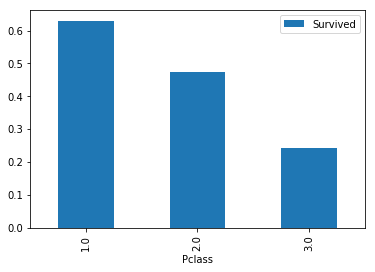

In [15]:
data[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar()

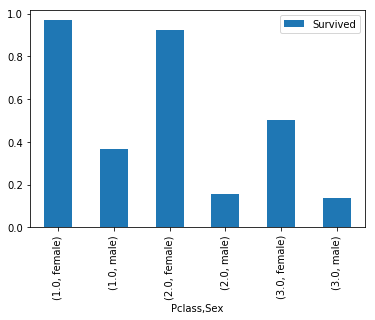

In [16]:
# 船舱等级 && 性别 和生存与否的关系 Pclass && Sex
data[['Sex','Pclass','Survived']].groupby(['Pclass','Sex']).mean().plot.bar()

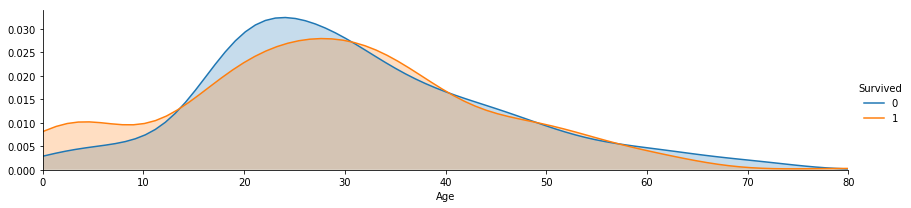

In [17]:
# 不同年龄下的是否生存的分布情况：

facet = sns.FacetGrid(data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, data['Age'].max()))
facet.add_legend()

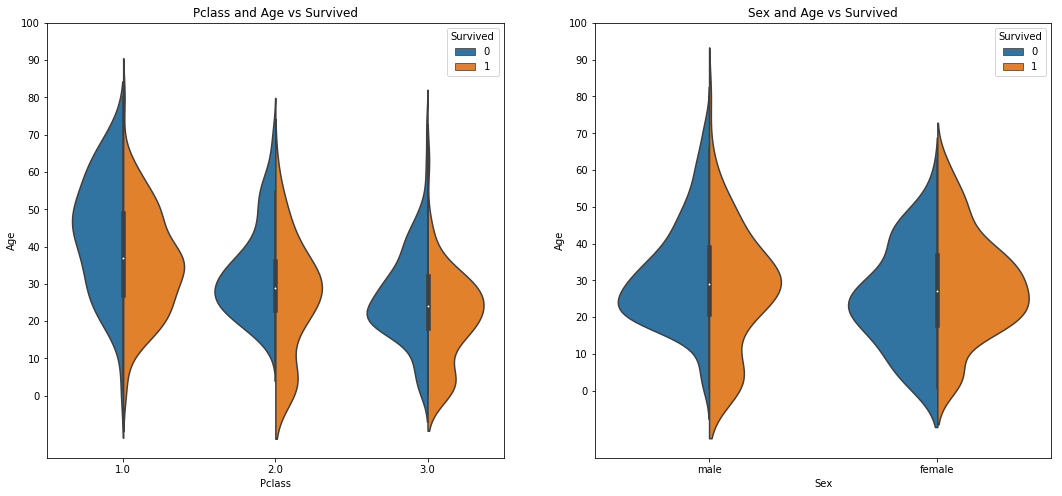

In [18]:
# 年龄 && 船舱等级 && 性别 与存活与否的关系 Age && Pclass && Sex
fig, ax = plt.subplots(1, 2, figsize = (18, 8))
sns.violinplot("Pclass", "Age", hue="Survived", data=data, split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))

sns.violinplot("Sex", "Age", hue="Survived", data=data, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))

plt.show()

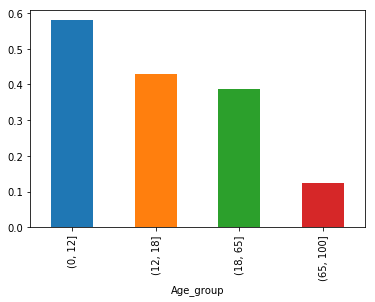

In [19]:
# 按照年龄，将乘客划分为儿童、少年、成年和老年，分析四个群体的生还情况：

bins = [0, 12, 18, 65, 100]
data['Age_group'] = pd.cut(data['Age'], bins)
by_age = data.groupby('Age_group')['Survived'].mean()
by_age.plot(kind = 'bar')

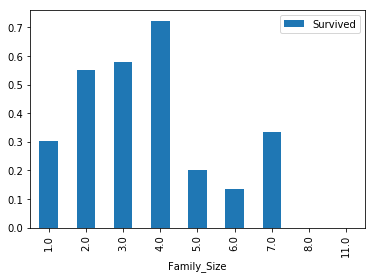

In [20]:
# 亲友的人数和存活与否的关系
data['Family_Size'] = data['Parch'] + data['SibSp'] + 1
data[['Family_Size','Survived']].groupby(['Family_Size']).mean().plot.bar()

## 5. 清洗数据

In [21]:
# 首先进行预处理
# 提取标签，构造训练集标签 y_
y_ = data.loc[:,'Survived']
y_0 = y_.map(lambda x: 0 if x==1 else 1)
y_1 = y_
y_ = pd.concat([y_0, y_1], axis=1)
# 重命名列名
y_.columns = ['Dead','Survived']
# 转换数据类型
y_ = y_.astype('float32')
# 获取 Numpy 格式的矩阵，便于 TensorFlow 处理
y_ = y_.values

In [22]:
# 提取需要考虑的字段作为特征，构造训练集数据 x
x = data.loc[:,['Name','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]

In [23]:
# 清洗训练集数据前
x.head(10)

,Name,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,"Braund, Mr. Owen Harris",3.0,male,22.0,1.0,0.0,7.250000,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1.0,female,38.0,1.0,0.0,71.283302,C
2,"Heikkinen, Miss. Laina",3.0,female,26.0,0.0,0.0,7.925000,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1.0,female,35.0,1.0,0.0,53.099998,S
4,"Allen, Mr. William Henry",3.0,male,35.0,0.0,0.0,8.050000,S
5,"Moran, Mr. James",3.0,male,NaN,0.0,0.0,8.458300,Q
6,"McCarthy, Mr. Timothy J",1.0,male,54.0,0.0,0.0,51.862499,S
7,"Palsson, Master. Gosta Leonard",3.0,male,2.0,3.0,1.0,21.075001,S
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",3.0,female,27.0,0.0,2.0,11.133300,S
9,"Nasser, Mrs. Nicholas (Adele Achem)",2.0,female,14.0,1.0,0.0,30.070801,C


In [24]:
# 清洗数据
# 将 Sex 列中的性别字符串替换为数字
x['Sex'] = x['Sex'].replace(['female', 'male'],[0,1]).astype('int32')
# 将 Embarked 出发地的字符替换为数字，同时将列中 NaN 值替换为 0
x['Embarked'] = x['Embarked'].fillna('S')
mapping = {'C':0,'Q':1,'S':2}
x['Embarked'] = x['Embarked'].map(mapping)
# 将 Fare 收入中为 NaN 的填充为中位数
x['Fare'] = x['Fare'].fillna(x['Fare'].median())

# 使用 随机森林 预测 Age 字段的缺失值
from sklearn.ensemble import RandomForestRegressor
age = data[['Age','Survived','Fare','Parch','SibSp','Pclass']]
age_notnull = age.loc[(data.Age.notnull())]
age_isnull = age.loc[(data.Age.isnull())]
X = age_notnull.values[:,1:]
Y = age_notnull.values[:,0]
rfr = RandomForestRegressor(n_estimators=1000,n_jobs=-1)
rfr.fit(X,Y)
predictAges = rfr.predict(age_isnull.values[:,1:])
x.loc[(x.Age.isnull()),'Age'] = predictAges

In [25]:
x.head(10)

,Name,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,"Braund, Mr. Owen Harris",3.0,1,22.000000,1.0,0.0,7.250000,2
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1.0,0,38.000000,1.0,0.0,71.283302,0
2,"Heikkinen, Miss. Laina",3.0,0,26.000000,0.0,0.0,7.925000,2
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1.0,0,35.000000,1.0,0.0,53.099998,2
4,"Allen, Mr. William Henry",3.0,1,35.000000,0.0,0.0,8.050000,2
5,"Moran, Mr. James",3.0,1,23.566933,0.0,0.0,8.458300,1
6,"McCarthy, Mr. Timothy J",1.0,1,54.000000,0.0,0.0,51.862499,2
7,"Palsson, Master. Gosta Leonard",3.0,1,2.000000,3.0,1.0,21.075001,2
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",3.0,0,27.000000,0.0,2.0,11.133300,2
9,"Nasser, Mrs. Nicholas (Adele Achem)",2.0,0,14.000000,1.0,0.0,30.070801,0


## 6. 特征工程

In [26]:
# 构造新的特征

# 添加 Child 特征，<=16 的为小孩子，设为1，否则为0
x['Child'] = x.Age.apply(lambda x: 1 if x<=16 else 0).astype('int32')

# 添加 FamilySize 特征，表示家族大小
x['FamilySize'] = x['SibSp'] + x['Parch'] + 1
x['FamilySize'] = x['FamilySize'].astype('int32')

# 添加 IsAlone 特征，表示是否独身一人。如果 FamilySize==1，则为1，否则为0
x['IsAlone'] = x.FamilySize.apply(lambda x: 1 if x==1 else 0)

# 添加 Age_bin 特征，划分年龄区间
x['Age_bin'] = pd.cut(x['Age'], bins=[0,16,32,48,1200], 
                    labels=['Children','Teenage','Adult','Elder'])
mapping = {'Children':0,'Teenage':1,'Adult':2,'Elder':3}
x['Age_bin'] = x['Age_bin'].map(mapping)


# 添加 Fare_bin 特征，划分收入区间
x['Fare_bin'] = pd.cut(x['Fare'], bins=[-1,7.91,14.45,31,12000], 
                    labels=['Low_fare','median_fare','Average_fare','high_fare'])
mapping = {'Low_fare':0,'median_fare':1,'Average_fare':2,'high_fare':3}
x['Fare_bin'] = x['Fare_bin'].map(mapping)

# 处理 Name 特征
import re
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
x['Title'] = x['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
x['Title'] = x['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                            'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

x['Title'] = x['Title'].replace('Mlle', 'Miss')
x['Title'] = x['Title'].replace('Ms', 'Miss')
x['Title'] = x['Title'].replace('Mme', 'Mrs')

mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
x['Title'] = x['Title'].map(mapping)
x['Title'] = x['Title'].fillna(0)

# 丢弃无用字段
x.drop(["Name", "Age", "Fare"], axis=1, inplace=True)

In [27]:
x.head(10)

,Pclass,Sex,SibSp,Parch,Embarked,Child,FamilySize,IsAlone,Age_bin,Fare_bin,Title
0,3.0,1,1.0,0.0,2,0,2,0,1,0,1
1,1.0,0,1.0,0.0,0,0,2,0,2,3,3
2,3.0,0,0.0,0.0,2,0,1,1,1,1,2
3,1.0,0,1.0,0.0,2,0,2,0,2,3,3
4,3.0,1,0.0,0.0,2,0,1,1,2,1,1
5,3.0,1,0.0,0.0,1,0,1,1,1,1,1
6,1.0,1,0.0,0.0,2,0,1,1,3,3,1
7,3.0,1,3.0,1.0,2,1,5,0,0,2,4
8,3.0,0,0.0,2.0,2,0,3,0,1,1,3
9,2.0,0,1.0,0.0,0,1,2,0,0,2,3


In [28]:
# 获取 Numpy 格式的矩阵，便于 TensorFlow 处理
x = x.values

## 7. 搭建神经网络（前向传播）

In [29]:
def input_placeholder(input_size, output_size):
    # 输入占位符
    x = tf.placeholder(dtype=tf.float32, shape=[None, input_size])
    y_ = tf.placeholder(dtype=tf.float32, shape=[None, output_size])
    keep_prob = tf.placeholder(tf.float32)

    return x, y_, keep_prob

def forward(x, w1, w2, b1, b2, keep_prob=1.0):
    # 模型结构
    # 定义一个多层感知机（MLP），最后加一个softmax归一化进行二分类
    # 输入定义9个神经元，隐藏层定义100个神经元，输出层定义两个神经元（二分类），然后做一个softmax
    
    a = tf.matmul(x, w1) + b1
    a = tf.nn.dropout(a, keep_prob=keep_prob)
    a = tf.nn.relu(a)
    y = tf.matmul(a, w2) + b2
    return y

def loss(y, y_):
    # 交叉熵 损失
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    return loss

def accuary(y, y_):
    # 预测准确率
    correct_pred = tf.equal(tf.argmax(y_, 1),tf.argmax(y,1))
    acc = tf.reduce_mean(tf.cast(correct_pred,tf.float32))
    return acc

## 8.训练（反向传播）

In [30]:
def Train():
    global x, y_
    # 训练过程
    X, Y_ = x, y_
    
    # 模型
    w1 = tf.Variable(tf.random_normal([input_size, hidden_size], stddev=1.0, seed=2.0))
    w2 = tf.Variable(tf.random_normal([hidden_size, output_size], stddev=1.0, seed=2.0))
    b1 = tf.Variable(tf.zeros([hidden_size]), name='bias1')
    b2 = tf.Variable(tf.zeros([output_size]), name='bias2')

    x, y_, keep_prob = model.input_placeholder(input_size, output_size)
    y = model.forward(x, w1, w2, b1, b2, keep_prob=keep_prob)
    loss = model.loss(y, y_)
    y = tf.nn.softmax(y)
    accuary = model.accuary(y, y_)

    # 定义训练（反向传播）过程
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    # tf saver
    saver = tf.train.Saver()

    with tf.Session() as sess:
        # 变量初始化
        init_op = tf.global_variables_initializer()
        sess.run(init_op)

        # 训练
        print('Train start...')
        for i in range(epoch):
            for j in range(len(Y_) // BATCH_SIZE + 1):
                start = j * BATCH_SIZE
                end = start + BATCH_SIZE
                # 反向传播
                _, loss_result, y_result, acc_result = sess.run([train_op, loss, y, accuary], feed_dict={x:X[start:end], y_:Y_[start:end], keep_prob: KEEP_PROB})
            # 输出每个 epoch 之后的 loss 和 准确率
            if i%400==0 or i==0 or i+1==epoch:
                print(i, sess.run([loss, accuary], feed_dict={x:X, y_:Y_, keep_prob: 1.0}))
        print('Train end.')

        # 保存模型到本地
        print('Saving model...')
        saver.save(sess, model_save_path)
        print('Save finally.')
        
        
Train()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Train start...
0 [9.0670805, 0.38047138]
400 [0.38138294, 0.8327722]
800 [0.3612593, 0.84624016]
1200 [0.3550232, 0.8518519]
1600 [0.350376, 0.8563412]
1999 [0.3486581, 0.8552188]
Train end.
Saving model...
Save finally.


## 9. 测试模型效果 && 生成提交结果

In [25]:
# 导入测试数据加载函数，处理方式和步骤3-5相似，详情请见代码
from train import get_test_data

In [26]:
# 定义测试过程 && 生成提交结果
def Test():
    # 测试
    # 提取测试数据
    X, Y_, PassengerId = get_test_data()

    # 模型
    w1 = tf.Variable(tf.random_normal([input_size, hidden_size], stddev=1.0, seed=2.0))
    w2 = tf.Variable(tf.random_normal([hidden_size, output_size], stddev=1.0, seed=2.0))
    b1 = tf.Variable(tf.zeros([hidden_size]), name='bias1')
    b2 = tf.Variable(tf.zeros([output_size]), name='bias2')

    x, y_, keep_prob = model.input_placeholder(input_size, output_size)
    y = model.forward(x, w1, w2, b1, b2, keep_prob=keep_prob)
    loss = model.loss(y, y_)
    y = tf.nn.softmax(y)
    accuary = model.accuary(y, y_)
    y = tf.argmax(y, 1)

    #保存模型对象saver
    saver = tf.train.Saver()

    with tf.Session() as sess:
        # 变量初始化
        saver.restore(sess, model_save_path)
        loss, y, acc_result = sess.run([loss, y, accuary], feed_dict={x:X, y_:Y_, keep_prob: 1.0})
        print('loss:',loss)
        print('accuary:',acc_result)
    
    # 生成输出文件
    # 准备输出数据
    Survived = y.reshape((-1,1))
    result = np.hstack((PassengerId, Survived))
    result = pd.DataFrame(result, columns=['PassengerId', 'Survived'])
    result.to_csv(output_file, sep=',', encoding='utf-8', index=False)

# 清除默认图的堆栈，并设置全局图为默认图 
tf.reset_default_graph() 
Test()

INFO:tensorflow:Restoring parameters from ./ckpt/model
loss: 0.841927
accuary: 0.8779904
